# --- DATA ANALYSIS PLAN ---

# Data preperation

## 1.	Data validation and exclusion

### 1.1 Participant comment review
Participant comments after testing will be reviewed to validate a proper test result. Comments pertaining to technical difficulties and/or disturbances that may have affected the test result will be reviewed by at least two of the authors and lead to exclusion if so judged. 

### 1.2 Non-native speaker exclusion
Furthermore, participants who are non-native Swedish speakers will be excluded in the analysis for CERAD learning, CERAD recall and FAS.

## 2.	Index score for Stroop
Index scores will be calculated for the second part of Stroop 
test (color-word incongruence) by taking the number of correctanswers divided by the time in seconds. 

## 3.	Data standardization
Data will then be standardized from raw scores according to the normative regression models for each cognitive test using age, 
education, input method and sex as predictors resulting in Z-scores, indicating standard deviations above or below expected score. For a full overview of the multiple linear regression models used, and how they were calculated, see (Mindmore, 2022; van den Hurk et al., 2021).

## 4.	Normality check
To test for normality, data will be visually inspected, and a subsequent Shapiro-Wilk test will be conducted.

# Primary analysis

## 5.	Primary hypothesis analysis
For the primary hypothesis, if data is acceptably normally distributed: parametric independent sample one-tailed t-tests will  be used to test for differences between the patient group compared to norms. Otherwise a one-sided Wilcoxon signed rank test  will be conducted. 

# Exploratory analysis

## 6. Generating virtual control group
a control group will be generated by using the predicted scores from normative regression models for the participants included in the study, leading to a virtual control group.
 
## 7. ANOVA for each test
After which an ANOVA with the three groups will be done.

## 8. Post-huc Tukey HSDs
Tukey post-hoc test will be done to test for pairwise comparisons

## 9. Simple linear regressions in memory domain
The tests in the memory domain (CERAD learning, CERAD delayed recall and Corsi) will be correlated to the sum-score of 6-QEMP using simple linear regression.

## 10. Simple linear regressions between subjective symptoms and cognitive test results
Each cognitive test will be correlated to the sum-scores of the SMBQ using simple linear regression.  




# Importing the necessary packages and loading data files

In [15]:
from mindmore_standardisation import mindmore_standardiser
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from test_occasion_calculator import what_test_occassion
from mindmore_standardisation import mindmore_standardiser
from MindmoreVirtualControls import MindmoreVirtualControl
import datetime
import EDA
import pingouin as pg

DataFile = pd.read_csv('Data/merged_datafile.csv',encoding='UTF-8', delimiter=';')
DataFile.rename(columns={'ICBTvs.TAU Sub _sum_Förmätn':'SubjectiveMemory'}, inplace=True)


C:\Users\FRF8\Anaconda3\envs\ICBTvsTAU\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\FRF8\Anaconda3\envs\ICBTvsTAU\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## 1. Data validation and exclusion

### 1.1 Participant comment review

At this point in analysis, all patient comments have been reviewed and no results were excluded for this reason.


 ### 1.2 Non-native speaker exclusion
 Marking participants for exclusion if non-native for CERAD and FAS


In [2]:
DataFile.loc[DataFile.MotherTongue == 0, 'Exclude'] = "Exclude FAS, CERAD"
DataFile.loc[DataFile.Exclude == 'Exclude FAS, CERAD', 'ReasonExclusion'] = "Non native"

DataFile.loc[DataFile.Exclude == 'Exclude FAS, CERAD', 'CERAD_LEARNING'] = np.nan
DataFile.loc[DataFile.Exclude == 'Exclude FAS, CERAD', 'CERAD_DELAYED'] = np.nan
DataFile.loc[DataFile.Exclude == 'Exclude FAS, CERAD', 'FAS_INDEX'] = np.nan

# Let's see how many are now excluded from the analysis
print("The number of excluded participants for CERAD Learning is: "+str(
      DataFile['CERAD_LEARNING'].isna().sum()))

print("The number of excluded participants for CERAD_DELAYED is: "+str(
DataFile['CERAD_DELAYED'].isna().sum()))

print("The number of excluded participants for FAS_INDEX is: "+str(
DataFile['FAS_INDEX'].isna().sum()))

The number of excluded participants for CERAD Learning is: 21
The number of excluded participants for CERAD_DELAYED is: 21
The number of excluded participants for FAS_INDEX is: 22


## 2. Index scores for Stroop

Due to a product update, index scores had already been calculated by the product

## 3.	Data standardization
Starting out with #3, standardisation. For a full review of the script. See mindmore_standardisation.py

In [3]:
x = mindmore_standardiser(DataFile)
merged_datafile = x.CERAD_learning()
merged_datafile = x.CERAD_recall()
merged_datafile = x.CORSI_FWD()
merged_datafile = x.FAS()
merged_datafile = x.SDMT()
merged_datafile = x.Stroop_index_standardizer()
merged_datafile = x.Stroop_inhibition_standardiser()


## 4.	Normality check
Let's move on to step #4, visually inspecting data and then conducting a ShapiroWilk test for Normality

Firstly creating a visualizations for all standardized scores


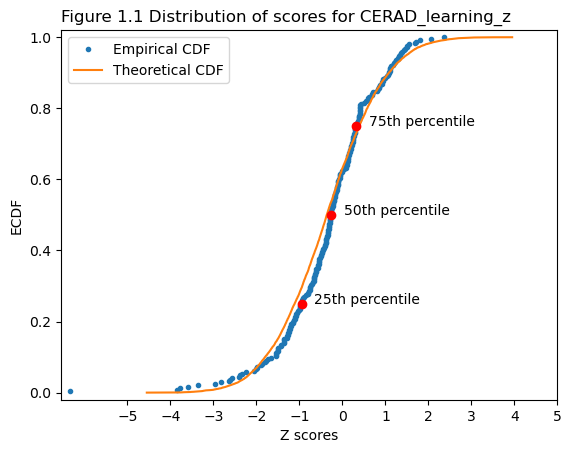

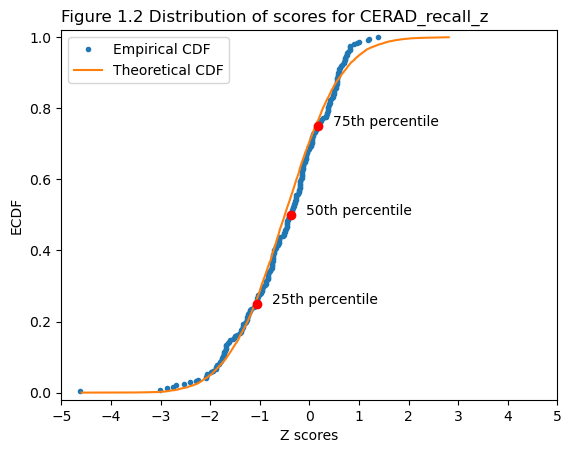

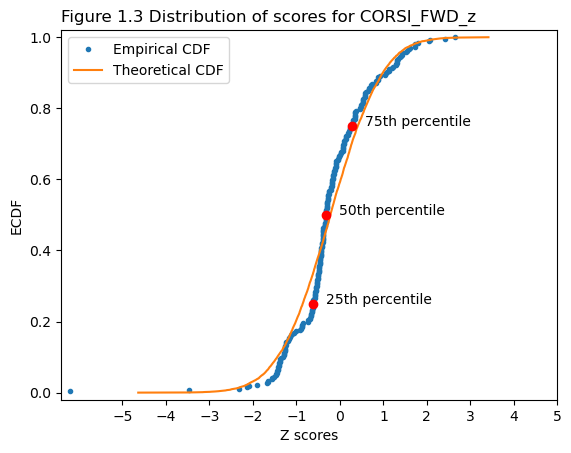

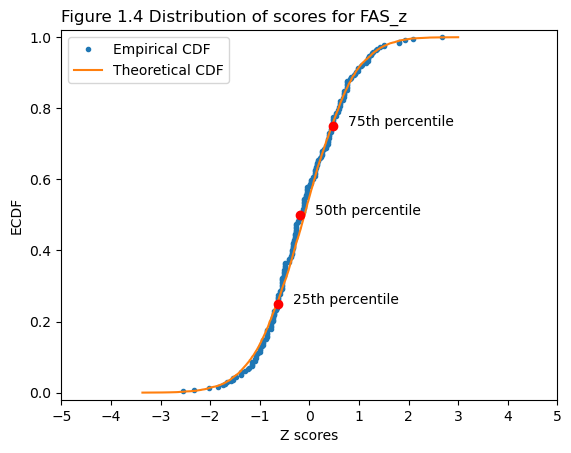

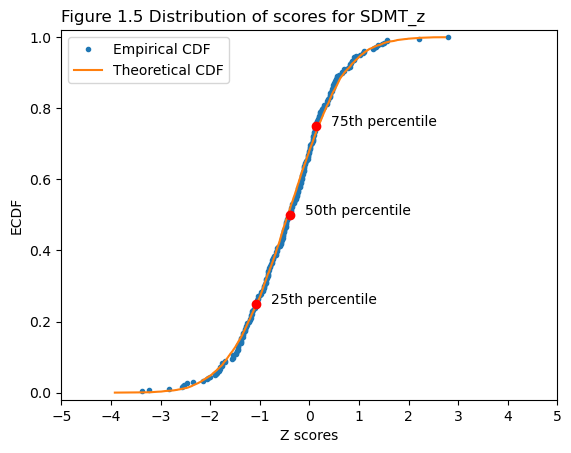

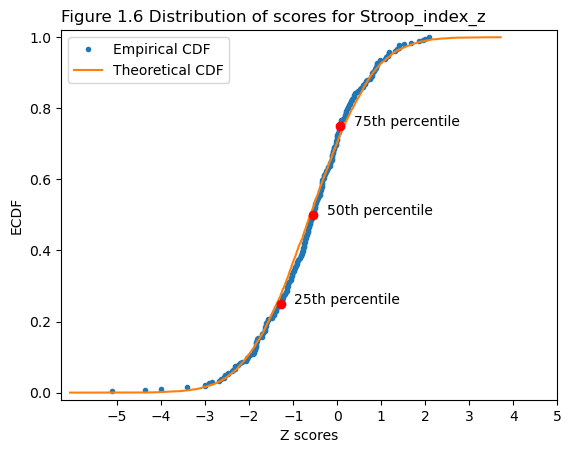

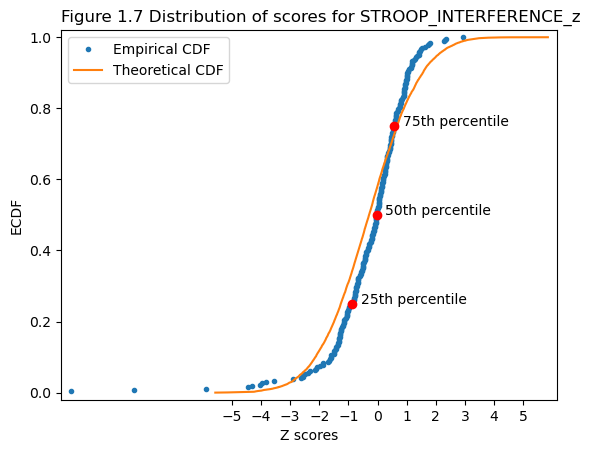

In [4]:
EDA.EDA(merged_datafile)


Looking at the data, we can see that it is fairly normally distributed with some extreme outliers. Let's do the Shapiro-Wilk test for normality.


In [6]:
standardised = merged_datafile.filter(regex='z$')   
ShapiroWilk = []    
for columns in standardised:
    ShapiroWilk.append(stats.shapiro(standardised[columns].dropna()))

col = standardised.columns.tolist()
ShapiroWilk = pd.DataFrame(ShapiroWilk, index=col).sort_values(by='pvalue', ascending=False)

print(ShapiroWilk.round(2))


                       statistic  pvalue
FAS_z                       0.99    0.55
SDMT_z                      0.99    0.44
Stroop_index_z              0.99    0.02
CERAD_recall_z              0.97    0.00
CERAD_learning_z            0.95    0.00
CORSI_FWD_z                 0.93    0.00
STROOP_INTERFERENCE_z       0.83    0.00


Based of these tests as well as a visual inspection of the data, FAS and SDMT follow rules of normality which means that we will do a one-sample t-test for these two tests, and a Wilcoxon signed-rank test for the others. Beginning with the t-tests.


# Primary analysis
## 5.	Primary hypothesis analysis


In [7]:
t_test = []
normal = standardised[['FAS_z', 'SDMT_z']]
for columns in normal:
        a = normal[columns].dropna()
        t_test.append(stats.ttest_1samp(a, 0, alternative='less'))

col = normal.columns.tolist()
t_test = pd.DataFrame(t_test, index = col)

t_test.round(4)

t_test = t_test.rename(columns = {'statistic': 't_test_statistic'})


And to calculate effect size (Cohen's d)

In [8]:
t_test['CohensD'] = 0
t_test = t_test.reset_index()
def CohensDOS(row): 
    return normal[row['index']].mean()/normal[row['index']].std()
    
t_test['CohensD'] = t_test.apply(lambda row: CohensDOS(row), axis=1)
t_test = t_test.set_index('index')

And for the non-normal inferential statistics.

In [9]:
Wilcoxon = []

nonnormal = standardised[['CERAD_learning_z', 'CERAD_recall_z',
                          'CORSI_FWD_z', 'Stroop_index_z','STROOP_INTERFERENCE_z',
                          ]]

for columns in nonnormal:
        a = nonnormal[columns].dropna()
        Wilcoxon.append(stats.wilcoxon(a, alternative='less'))

col = nonnormal.columns.tolist()
Wilcoxon = pd.DataFrame(Wilcoxon, index = col)

Wilcoxon.round(4)

Wilcoxon = Wilcoxon.rename(columns = {'statistic': 'Wilcoxon_statistic'})


Calculating effect size for Wilcoxon using Rank-Biserial correlation (Kirby, 2014)

In [10]:
Wilcoxon['RankBiserial'] = 0

Wilcoxon = Wilcoxon.reset_index()

def RankBiserial(row): 
    
    d = nonnormal[nonnormal[row['index']] != 0]
    d = nonnormal[row['index']].dropna()

    r = stats.rankdata(abs(d))
    rsum = r.sum()
    r_plus = np.sum((d > 0) * r)
    r_minus = np.sum((d < 0) * r)
    rbc = r_plus / rsum - r_minus / rsum
    return rbc

    
Wilcoxon['RankBiserial'] = Wilcoxon.apply(lambda row: RankBiserial(row), axis=1)
Wilcoxon = Wilcoxon.set_index('index')

Summarizing it into a descriptive table

In [11]:
DescriptiveTable = standardised.describe()
DescriptiveTable = DescriptiveTable.transpose()

DescriptiveTable = DescriptiveTable.merge(t_test, left_index=True, right_index=True, 
                       how='outer').merge(Wilcoxon, left_index=True,
                                          right_index=True, how='outer')
DescriptiveTable.drop(labels=['25%', '50%', '75%'], axis=1, inplace=True)

print(DescriptiveTable.round(8))

                       count      mean       std        min       max  \
CERAD_learning_z       245.0 -0.334515  1.128791  -6.327918  2.371209   
CERAD_recall_z         245.0 -0.501192  0.921808  -4.617542  1.392112   
CORSI_FWD_z            266.0 -0.218479  0.950105  -6.211740  2.642359   
FAS_z                  244.0 -0.106253  0.818160  -2.547825  2.681607   
SDMT_z                 266.0 -0.440868  0.924864  -3.375359  2.792290   
STROOP_INTERFERENCE_z  266.0 -0.278261  1.445925 -10.524169  2.939983   
Stroop_index_z         266.0 -0.617332  1.126034  -5.106889  2.094363   

                       t_test_statistic  pvalue_x   CohensD  \
CERAD_learning_z                    NaN       NaN       NaN   
CERAD_recall_z                      NaN       NaN       NaN   
CORSI_FWD_z                         NaN       NaN       NaN   
FAS_z                         -2.028605  0.021795 -0.129868   
SDMT_z                        -7.774494  0.000000 -0.476685   
STROOP_INTERFERENCE_z               N

From the t-tests and the Wilcoxon tests we can observe a difference between patients with stress related mental disorders and the normative sample on every measure. Let's see if we can visualize it with the means for each cognitive test with 95% confidence interval (assuming normality)

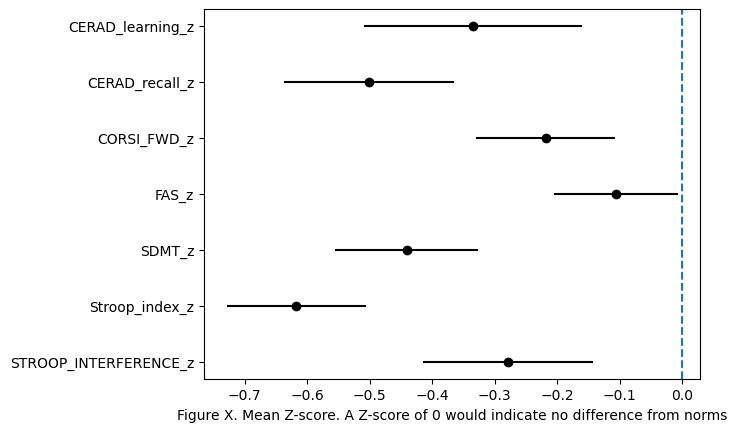

In [12]:
def W_array(array, conf=0.95): # function that returns W based on the array provided
    t = stats.t(df = len(array) - 1).ppf((1 + conf) /2)
    W = t * np.std(array, ddof=1) / np.sqrt(len(array))
    return W # the error

CI = list()
mean_list = list()
for columns in standardised:
    CI.append((W_array(standardised[columns]))) # makes a list of W for each array
    mean_list.append(np.mean(standardised[columns])) # same for the means to plot

#Getting the order correct
mean_list.reverse()
column_list = standardised.columns.tolist()
column_list.reverse()

plt.errorbar(x=mean_list, y=range(len(standardised.columns.tolist())), xerr=CI, fmt='o', color='k')
plt.axvline(0, ls='--') # this is only to demonstrate that 95%
                          # of the 95% CI contain the actual mean
plt.yticks(range(len(standardised.columns.tolist())),column_list)
plt.xlabel("Figure X. Mean Z-score. A Z-score of 0 would indicate no difference from norms")

plt.show();


# Exploratory analysis

## 6. Generating virtual control group


In [13]:
ControlGroup = merged_datafile.copy()

ControlGroup['diagnosis'] = "Virtual control"

x = MindmoreVirtualControl(ControlGroup)    
ControlGroup = x.CERAD_learning()
ControlGroup = x.CERAD_recall()
ControlGroup = x.CORSI_FWD()
ControlGroup = x.FAS()
ControlGroup = x.SDMT()
ControlGroup = x.Stroop_index_VC()
ControlGroup = x.Stroop_inhibition_VC()

ControlGroup = ControlGroup.drop(columns=['CERAD_learning_z', 'CERAD_recall_z',
'CORSI_FWD_z', 'FAS_z', 'SDMT_z', 'Stroop_index_z',
'STROOP_INTERFERENCE_z', 'SubjectiveMemory', 'CERAD_LEARNING_PREDICTED',
'CERAD_DELAYED_PREDICTED', 'FAS_predicted'])

# And now standardizing this file for a more appropriate analysis of pairwise comparisons
x = mindmore_standardiser(ControlGroup)
ControlGroup = x.CERAD_learning()
ControlGroup = x.CERAD_recall()
ControlGroup = x.CORSI_FWD()
ControlGroup = x.FAS()
ControlGroup = x.SDMT()
ControlGroup = x.Stroop_index_standardizer()
ControlGroup = x.Stroop_inhibition_standardiser()


# And excluding the participants as was previously generated
ControlGroup.loc[ControlGroup.MotherTongue == 0, 'Exclude'] = "Exclude FAS, CERAD"
ControlGroup.loc[ControlGroup.Exclude == 'Exclude FAS, CERAD', 'ReasonExclusion'] = "Non native"

ControlGroup.loc[ControlGroup.Exclude == 'Exclude FAS, CERAD', 'CERAD_LEARNING'] = np.nan
ControlGroup.loc[ControlGroup.Exclude == 'Exclude FAS, CERAD', 'CERAD_DELAYED'] = np.nan
ControlGroup.loc[ControlGroup.Exclude == 'Exclude FAS, CERAD', 'FAS_INDEX'] = np.nan


## 7. ANOVA for each test

Now that a virtual control group is generated, we can move on to do an ANOVA with our three groups. Please note that we are no longer looking at standardised scores but instead an comparison of the predicted score of a generated control group vs the actual scores for each diagnostic group


In [17]:
#Now that a virtual control group is generated, we can move on to do an ANOVA
# with our three groups. Please note that we are looking at standardised scores

AnovaGroup = pd.concat([merged_datafile, ControlGroup])

# AnovaGroup.to_csv('Exports/DataWControlGroup20221125.csv', encoding='UTF-8')                                        
                                      
ADGroup = AnovaGroup[AnovaGroup['diagnosis'] == 'Adjustment disorder']
EDGroup = AnovaGroup[AnovaGroup['diagnosis'] == 'Exhaustion disorder']
VirtualGroup = AnovaGroup[AnovaGroup['diagnosis'] == 'Virtual control']

AnovaCol = ['CERAD_learning_z', 'CERAD_recall_z',
'CORSI_FWD_z', 'FAS_z', 'SDMT_z', 'Stroop_index_z',
'STROOP_INTERFERENCE_z']
ANOVA = []
for x in AnovaCol:
    AD = ADGroup[x].dropna()
    ED = EDGroup[x].dropna()
    VG = VirtualGroup[x].dropna()
    
    # ANOVA.append(stats.f_oneway(AD, ED, VG))
    ANOVA.append(pg.anova(data = AnovaGroup, dv=x, between='diagnosis'))

   
ANOVA = pd.concat(ANOVA)
ANOVA = ANOVA.set_index(pd.Series(AnovaCol))

ANOVA = ANOVA.round({'F':2, "np2":2, "p-unc":3})

ANOVA[['ddof1', 'ddof2', 'F', 'p-unc', 'np2']] = ANOVA[['ddof1',
                'ddof2', 'F', 'p-unc', 'np2']].apply(lambda x: x.astype(str).str.lstrip('0'))

print(ANOVA)

                          Source ddof1 ddof2      F p-unc  np2
CERAD_learning_z       diagnosis     2   508   6.79  .001  .03
CERAD_recall_z         diagnosis     2   508  14.27    .0  .05
CORSI_FWD_z            diagnosis     2   529    3.8  .023  .01
FAS_z                  diagnosis     2   507    .85  .427   .0
SDMT_z                 diagnosis     2   529  11.26    .0  .04
Stroop_index_z         diagnosis     2   529  26.91    .0  .09
STROOP_INTERFERENCE_z  diagnosis     2   529   3.97   .02  .01


## 8. Post-huc Tukey HSDs

It seems we have a significant result in difference between the groups for all of our cognitive tests. Let's do the post-hoc analysis using pairwise comparisons with Tukey HSD. We'll also include a visualization.


CERAD_learning_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.143     0.547    -0.177     0.463
 (0 - 2)     -0.259     0.074    -0.537     0.019
 (1 - 0)     -0.143     0.547    -0.463     0.177
 (1 - 2)     -0.402     0.001    -0.671    -0.132
 (2 - 0)      0.259     0.074    -0.019     0.537
 (2 - 1)      0.402     0.001     0.132     0.671



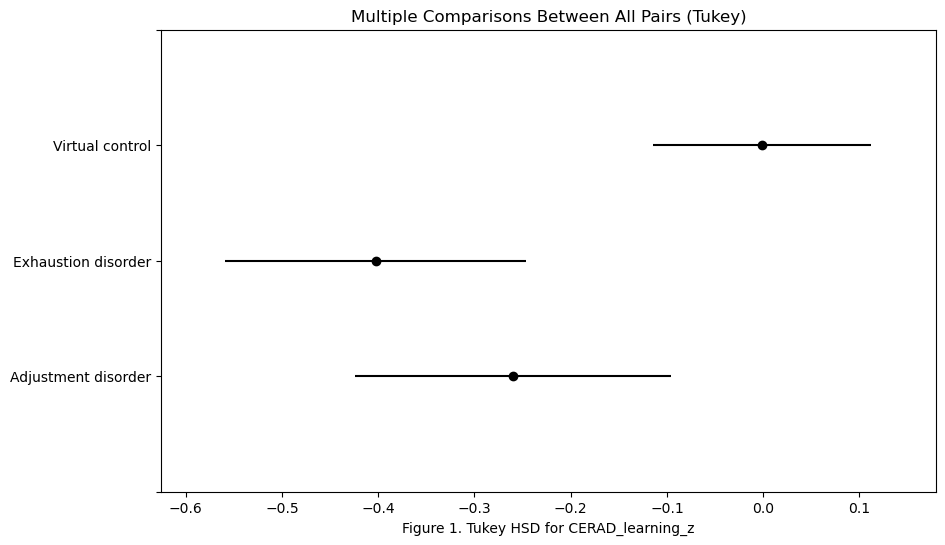

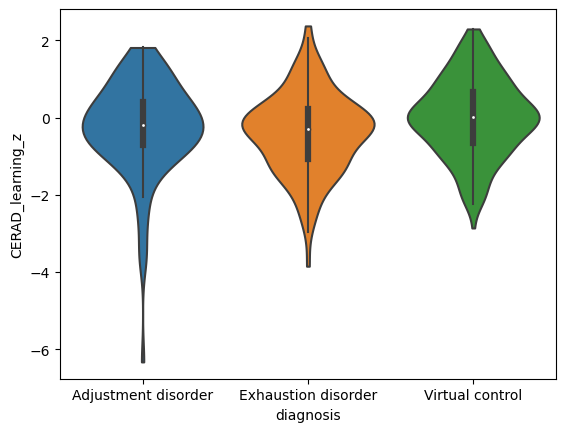

Results for cognitive test CERAD_learning_z                 group1               group2  meandiff   p-adj   lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.1428  0.5469 -0.4631  0.1775   
1  Adjustment disorder      Virtual control    0.2587  0.0740 -0.0191  0.5365   
2  Exhaustion disorder      Virtual control    0.4015  0.0014  0.1322  0.6709   

   reject  
0   False  
1   False  
2    True  
CERAD_recall_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.092     0.688    -0.170     0.355
 (0 - 2)     -0.360     0.001    -0.588    -0.132
 (1 - 0)     -0.092     0.688    -0.355     0.170
 (1 - 2)     -0.452     0.000    -0.673    -0.231
 (2 - 0)      0.360     0.001     0.132     0.588
 (2 - 1)      0.452     0.000     0.231     0.673



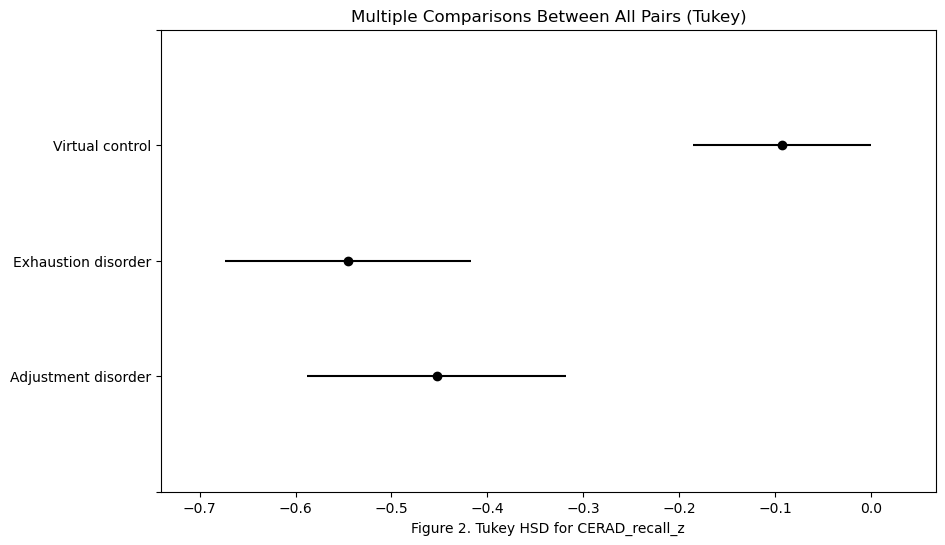

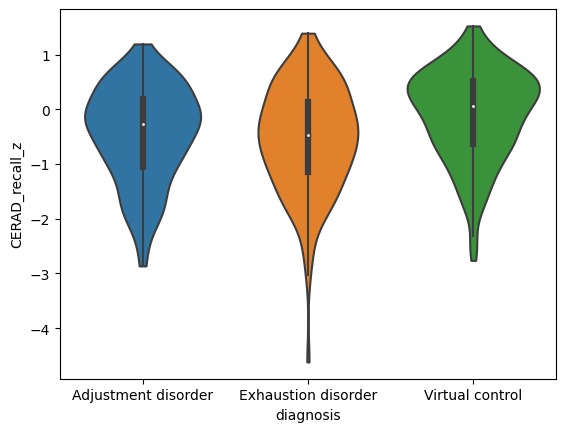

Results for cognitive test CERAD_recall_z                 group1               group2  meandiff   p-adj   lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.0921  0.6877 -0.3547  0.1704   
1  Adjustment disorder      Virtual control    0.3600  0.0007  0.1323  0.5877   
2  Exhaustion disorder      Virtual control    0.4521  0.0000  0.2313  0.6729   

   reject  
0   False  
1    True  
2    True  
CORSI_FWD_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.008     0.998    -0.283     0.299
 (0 - 2)     -0.238     0.072    -0.491     0.016
 (1 - 0)     -0.008     0.998    -0.299     0.283
 (1 - 2)     -0.246     0.057    -0.497     0.005
 (2 - 0)      0.238     0.072    -0.016     0.491
 (2 - 1)      0.246     0.057    -0.005     0.497



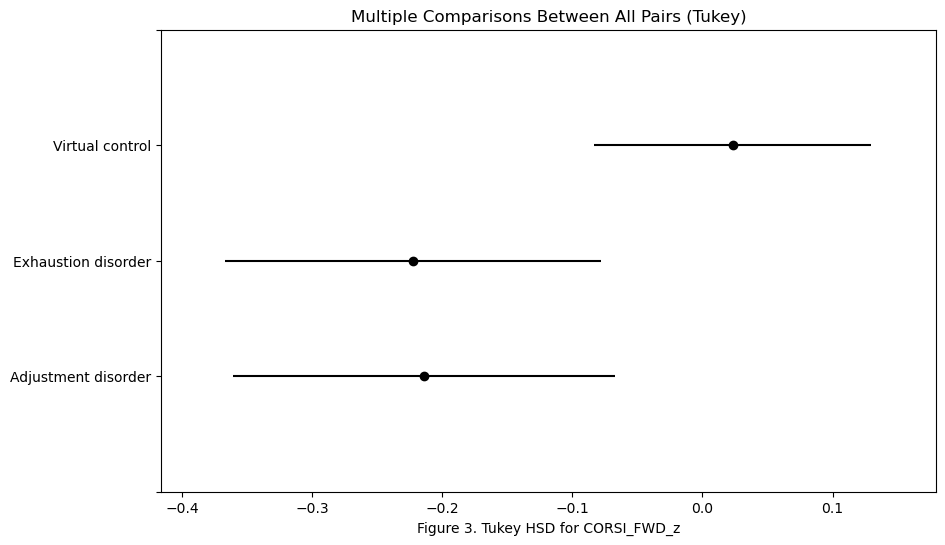

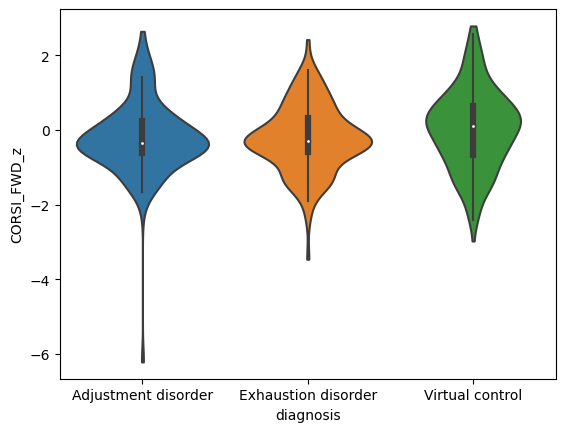

Results for cognitive test CORSI_FWD_z                 group1               group2  meandiff   p-adj   lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.0080  0.9977 -0.2993  0.2833   
1  Adjustment disorder      Virtual control    0.2376  0.0716 -0.0159  0.4911   
2  Exhaustion disorder      Virtual control    0.2456  0.0567 -0.0054  0.4966   

   reject  
0   False  
1   False  
2   False  
FAS_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.147     0.409    -0.124     0.419
 (0 - 2)      0.055     0.847    -0.180     0.290
 (1 - 0)     -0.147     0.409    -0.419     0.124
 (1 - 2)     -0.093     0.608    -0.321     0.136
 (2 - 0)     -0.055     0.847    -0.290     0.180
 (2 - 1)      0.093     0.608    -0.136     0.321



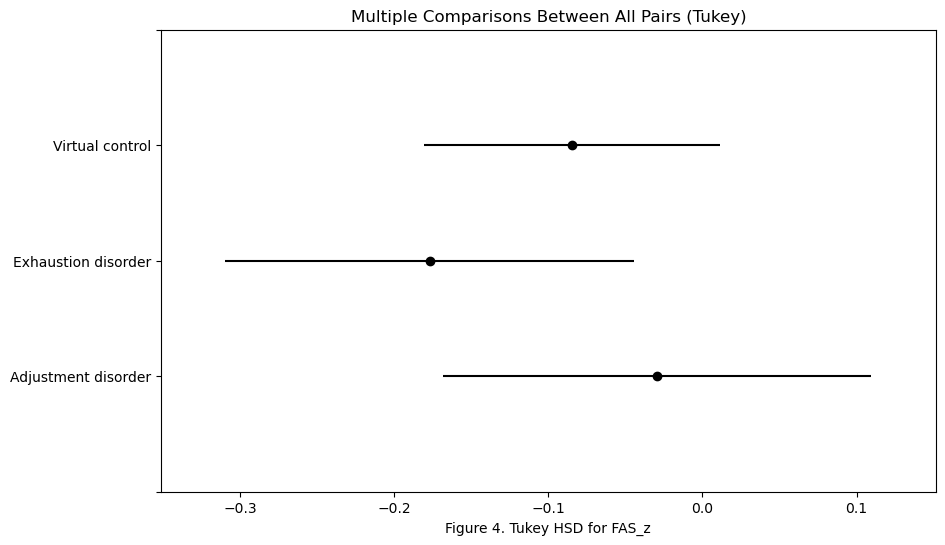

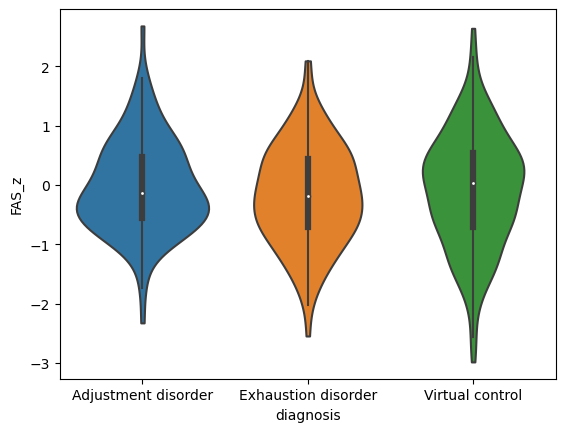

Results for cognitive test FAS_z                 group1               group2  meandiff   p-adj  lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.1475  0.4089 -0.419  0.1240   
1  Adjustment disorder      Virtual control   -0.0550  0.8466 -0.290  0.1801   
2  Exhaustion disorder      Virtual control    0.0925  0.6079 -0.136  0.3210   

   reject  
0   False  
1   False  
2   False  
SDMT_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.205     0.197    -0.074     0.484
 (0 - 2)     -0.268     0.027    -0.511    -0.024
 (1 - 0)     -0.205     0.197    -0.484     0.074
 (1 - 2)     -0.473     0.000    -0.713    -0.232
 (2 - 0)      0.268     0.027     0.024     0.511
 (2 - 1)      0.473     0.000     0.232     0.713



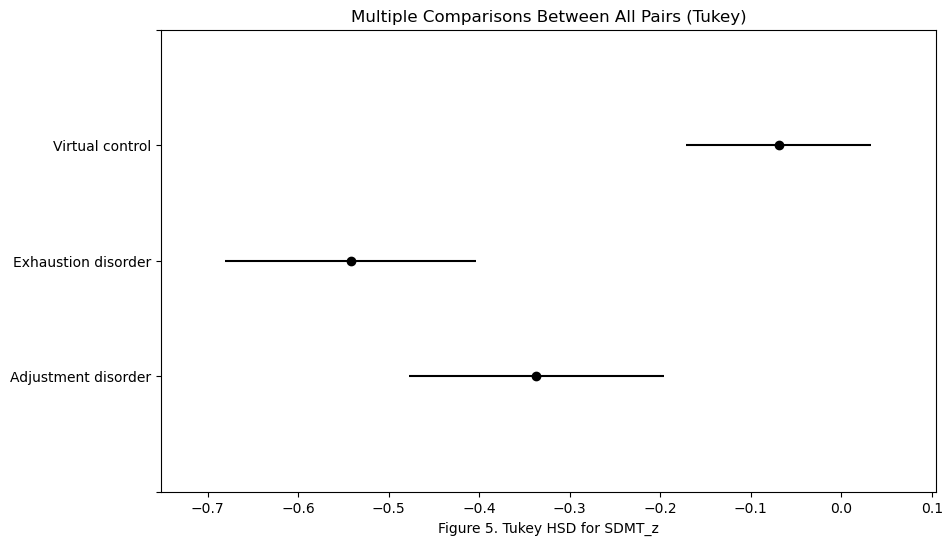

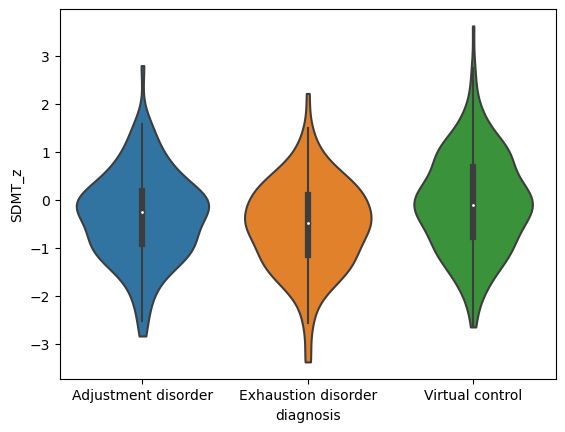

Results for cognitive test SDMT_z                 group1               group2  meandiff   p-adj   lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.2050  0.1970 -0.4844  0.0744   
1  Adjustment disorder      Virtual control    0.2676  0.0269  0.0244  0.5107   
2  Exhaustion disorder      Virtual control    0.4726  0.0000  0.2318  0.7133   

   reject  
0   False  
1    True  
2    True  
Stroop_index_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.270     0.093    -0.034     0.573
 (0 - 2)     -0.505     0.000    -0.769    -0.241
 (1 - 0)     -0.270     0.093    -0.573     0.034
 (1 - 2)     -0.774     0.000    -1.036    -0.513
 (2 - 0)      0.505     0.000     0.241     0.769
 (2 - 1)      0.774     0.000     0.513     1.036



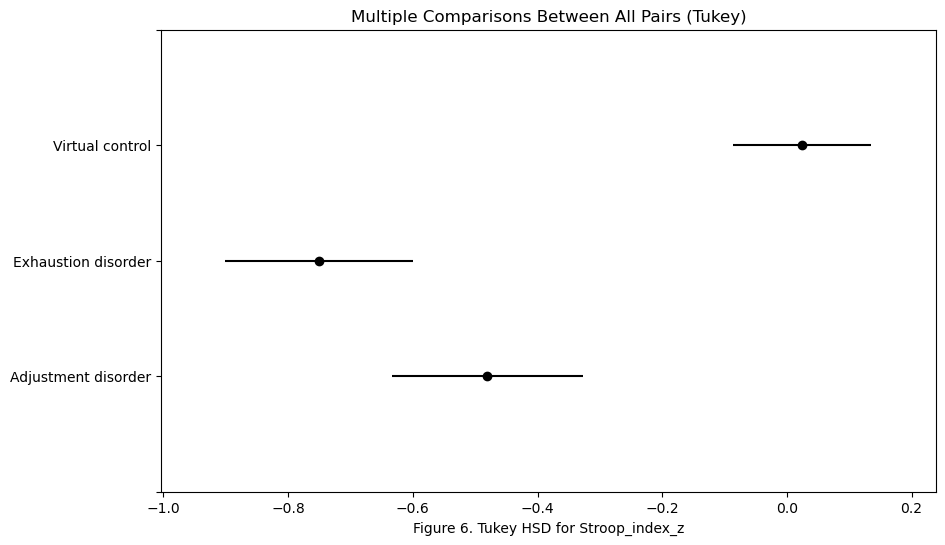

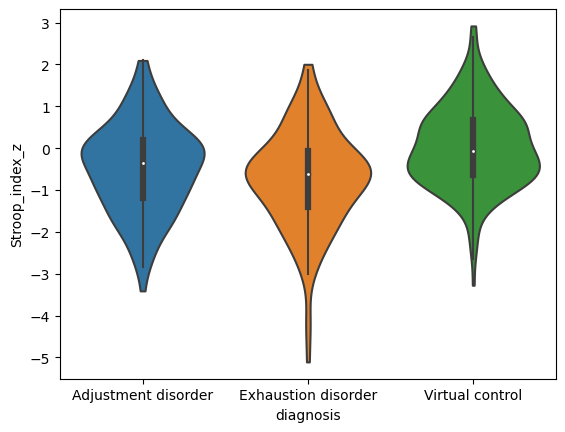

Results for cognitive test Stroop_index_z                 group1               group2  meandiff   p-adj   lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.2697  0.0928 -0.5729  0.0336   
1  Adjustment disorder      Virtual control    0.5047  0.0000  0.2407  0.7686   
2  Exhaustion disorder      Virtual control    0.7744  0.0000  0.5131  1.0356   

   reject  
0   False  
1    True  
2    True  
STROOP_INTERFERENCE_z results are Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.300     0.132    -0.066     0.666
 (0 - 2)     -0.074     0.848    -0.392     0.244
 (1 - 0)     -0.300     0.132    -0.666     0.066
 (1 - 2)     -0.374     0.015    -0.689    -0.059
 (2 - 0)      0.074     0.848    -0.244     0.392
 (2 - 1)      0.374     0.015     0.059     0.689



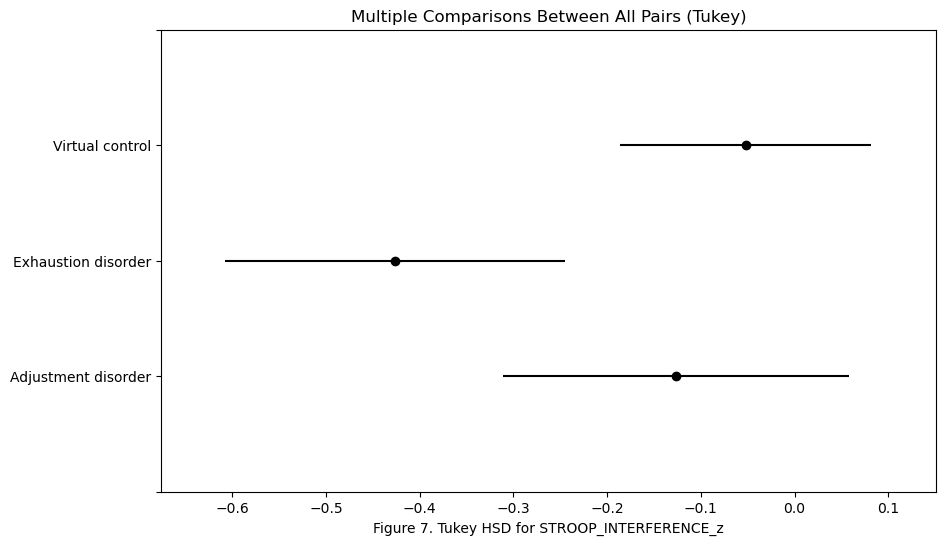

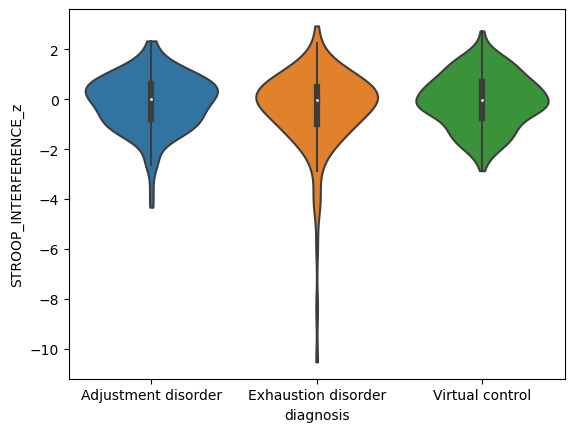

Results for cognitive test STROOP_INTERFERENCE_z                 group1               group2  meandiff   p-adj   lower   upper  \
0  Adjustment disorder  Exhaustion disorder   -0.2998  0.1324 -0.6658  0.0661   
1  Adjustment disorder      Virtual control    0.0740  0.8485 -0.2445  0.3925   
2  Exhaustion disorder      Virtual control    0.3738  0.0152  0.0586  0.6891   

   reject  
0   False  
1   False  
2    True  
                                    group1               group2 meandiff  \
CERAD_learning_z       Adjustment disorder  Exhaustion disorder    -0.14   
CERAD_learning_z       Adjustment disorder      Virtual control      .26   
CERAD_learning_z       Exhaustion disorder      Virtual control       .4   
CERAD_recall_z         Adjustment disorder  Exhaustion disorder    -0.09   
CERAD_recall_z         Adjustment disorder      Virtual control      .36   
CERAD_recall_z         Exhaustion disorder      Virtual control      .45   
CORSI_FWD_z            Adjustment disorder  Ex

In [20]:
TukeyList = []

for x in AnovaCol:
    TukeyList.append(x)
    TukeyList.append(x)
    TukeyList.append(x)


TukeyHSD = []
counter = 1

for x in AnovaCol:
    AD = ADGroup[x].dropna()
    ED = EDGroup[x].dropna()
    VG = VirtualGroup[x].dropna()
    
    ANOVAGroupsNA = AnovaGroup.filter(items=[x, 'diagnosis']).dropna()
    print(x+" results are "+str(stats.tukey_hsd(AD, ED, VG)))

    tukey = pairwise_tukeyhsd(endog=ANOVAGroupsNA[x],
                          groups=ANOVAGroupsNA['diagnosis'],
                          alpha=0.05)
    
    #Doing some plotting to visualize group differences
    tukey.plot_simultaneous(xlabel = "Figure "+str(counter)+". Tukey HSD for "+str(x))
    plt.show()
    
    sns.violinplot(data=ANOVAGroupsNA, x='diagnosis', y=x, cut=0)
    plt.show()

    
    counter += 1


    tukeyTable = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    print("Results for cognitive test "+x+" "+str(tukeyTable))
    TukeyHSD.append(tukeyTable)
    

TukeyHSD = pd.concat(TukeyHSD)

TukeyHSD = TukeyHSD.set_index(pd.Series(TukeyList))

TukeyHSD = TukeyHSD.round({'meandiff':2, 'p-adj':3,'lower':2,'upper':2})


TukeyHSD[['meandiff', 'p-adj', 'lower', 'upper']] = TukeyHSD[[
               'meandiff', 'p-adj', 'lower', 'upper']].apply(lambda x: x.astype(str).str.lstrip('0'))

TukeyHSD['95% CI'] = "["+TukeyHSD['lower']+", "+TukeyHSD['upper']+"]"
TukeyHSD.drop(columns=['lower', 'upper', 'reject'], inplace=True)
print(TukeyHSD)

## 9. Simple linear regressions in memory domain
Now let's move on to the regressions. Firstly we'll start by looking at the relationship between subjective memory impairment and our memory tests

In [21]:
MemoryRegressions = []
MemTests = ['CERAD_learning_z', 'CERAD_recall_z', 'CORSI_FWD_z']
for tests in MemTests:
    a = merged_datafile[merged_datafile[tests].notnull()]
    MemoryRegressions.append(stats.linregress(a[tests],
                                              y=a['SubjectiveMemory'],
                                              alternative='two-sided'))

MemoryRegressions = pd.DataFrame(MemoryRegressions, index=MemTests)

print(MemoryRegressions)


                     slope  intercept    rvalue    pvalue    stderr
CERAD_learning_z -0.759242  14.370512 -0.214767  0.000714  0.221490
CERAD_recall_z   -0.601144  14.323201 -0.138865  0.029780  0.275013
CORSI_FWD_z      -0.142458  14.615492 -0.034191  0.578775  0.256283


Now there's seems to be a small association between subjective memory impairment and the CERAD tests. Let's plot it using a scatter plots

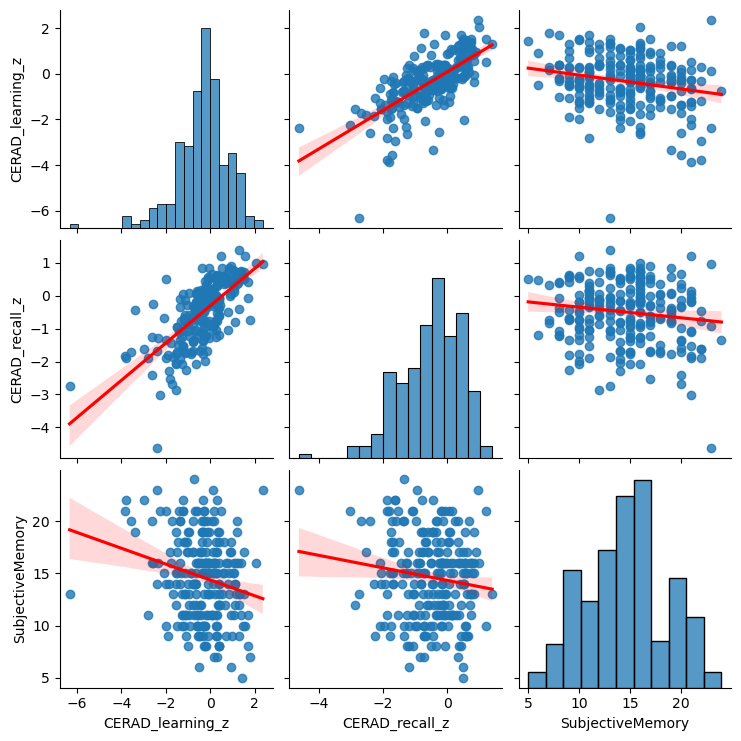

In [22]:
sns.pairplot(merged_datafile[['CERAD_learning_z', 'CERAD_recall_z'
                              , 'SubjectiveMemory']], kind="reg",
             plot_kws={'line_kws':{'color':'red'}})


## 10. Simple linear regressions between subjective symptoms and cognitive test results
And now for the regressions for the subjective symtom measure SMBQ and the cognitive test results

In [23]:
LinearRegressions = []
for columns in AnovaCol:
        a = merged_datafile[merged_datafile[columns].notnull()]
        LinearRegressions.append(stats.linregress(a[columns],
                                                  y=a['SMBQ'],
                                                  alternative='two-sided'))

LinearRegressions = pd.DataFrame(LinearRegressions, index=AnovaCol)

print(LinearRegressions)

                          slope  intercept    rvalue    pvalue    stderr
CERAD_learning_z      -0.007443   5.205673 -0.009179  0.886335  0.052015
CERAD_recall_z        -0.041136   5.187546 -0.041429  0.518654  0.063642
CORSI_FWD_z           -0.035741   5.200838 -0.037893  0.538344  0.058010
FAS_z                 -0.180406   5.183928 -0.161537  0.011506  0.070848
SDMT_z                -0.057750   5.183186 -0.059600  0.332882  0.059530
Stroop_index_z        -0.039627   5.184183 -0.049792  0.418653  0.048921
STROOP_INTERFERENCE_z -0.060253   5.191880 -0.097217  0.113687  0.037965


For FAS but not the other tests are we finding a relationship to SMBQ. Let's visualize the correlation matrix using a heatmap

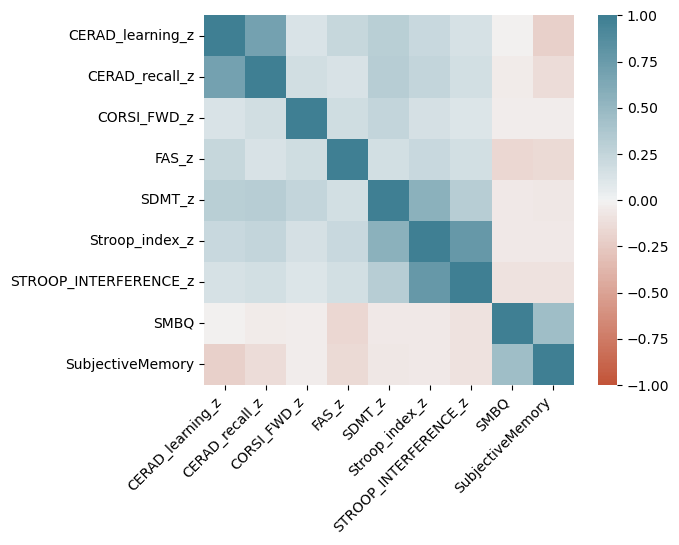

In [53]:
Heatmap = merged_datafile[standardised.columns.tolist()+['SMBQ', 'SubjectiveMemory']]
corr = Heatmap.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


And we can also visualize the relationship between the subjective symptom ratings split by diagnosis

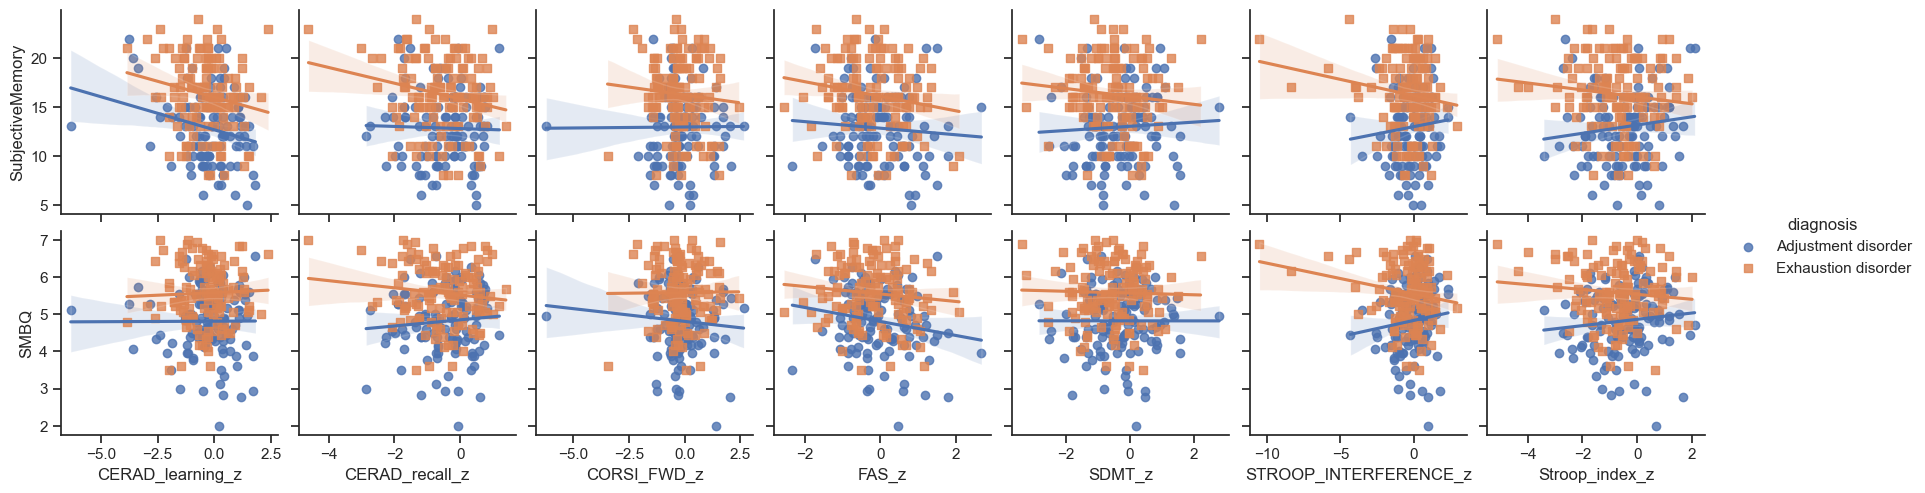

In [26]:
sns.set_theme(style="ticks")

sns.pairplot(merged_datafile[['CERAD_learning_z',
 'CERAD_recall_z',
 'CORSI_FWD_z',
 'FAS_z',
 'SDMT_z',
 'STROOP_INTERFERENCE_z',
 'Stroop_index_z',
                              'SubjectiveMemory', 'SMBQ',
                              'diagnosis']], hue='diagnosis',
             kind='reg', y_vars=['SubjectiveMemory', 'SMBQ'],
             x_vars=['CERAD_learning_z',
              'CERAD_recall_z',
              'CORSI_FWD_z',
              'FAS_z',
              'SDMT_z',
              'STROOP_INTERFERENCE_z',
              'Stroop_index_z'],
             markers=["o", "s"])

plt.show()